In [ ]:
# install a specific version of tensorflow if needed

In [1]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-02-03 10:06:26.810112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-03 10:06:30.944393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


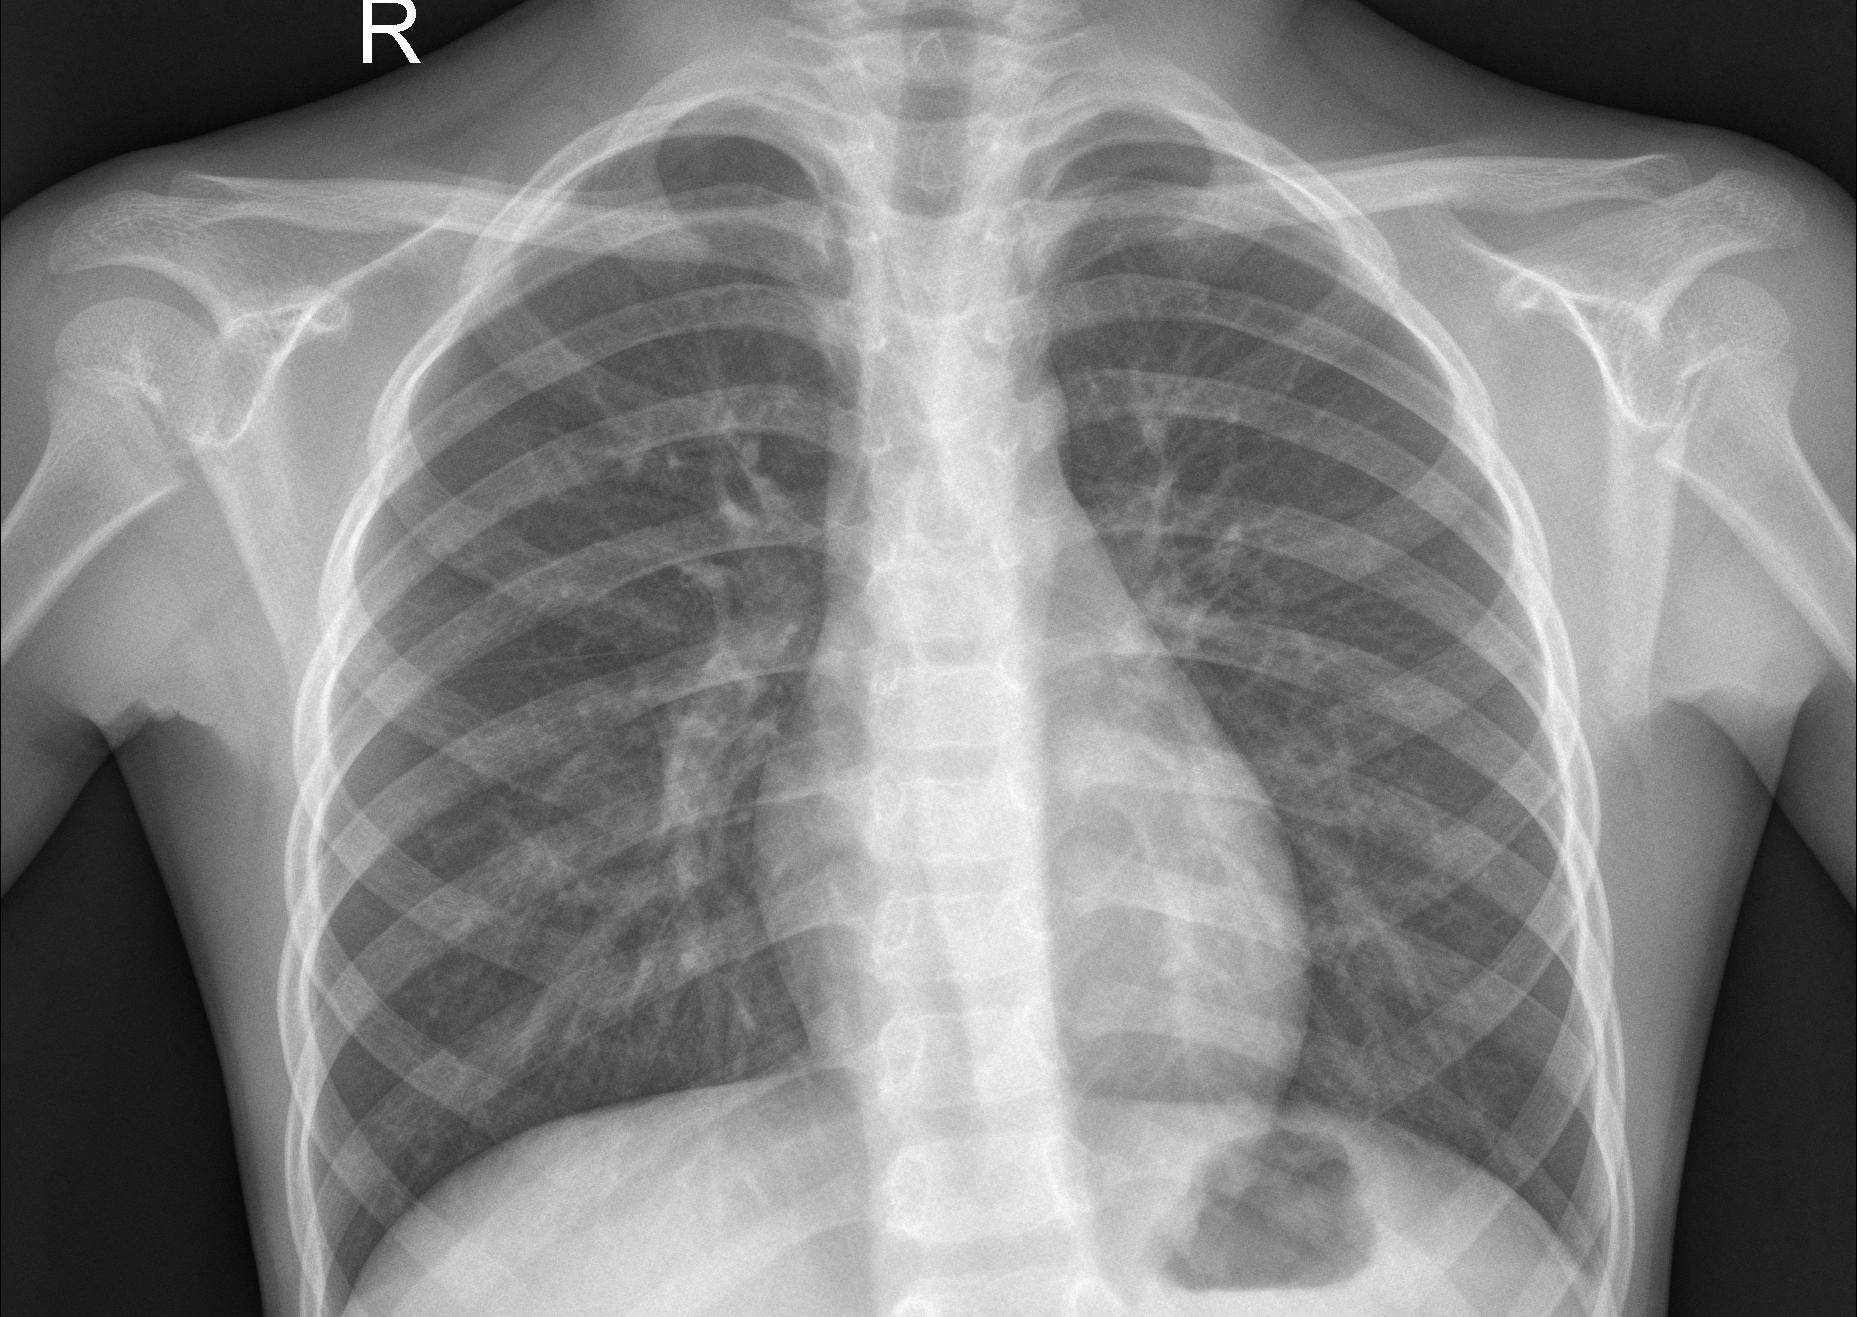

In [2]:
image = PIL.Image.open('../kaggle/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

image

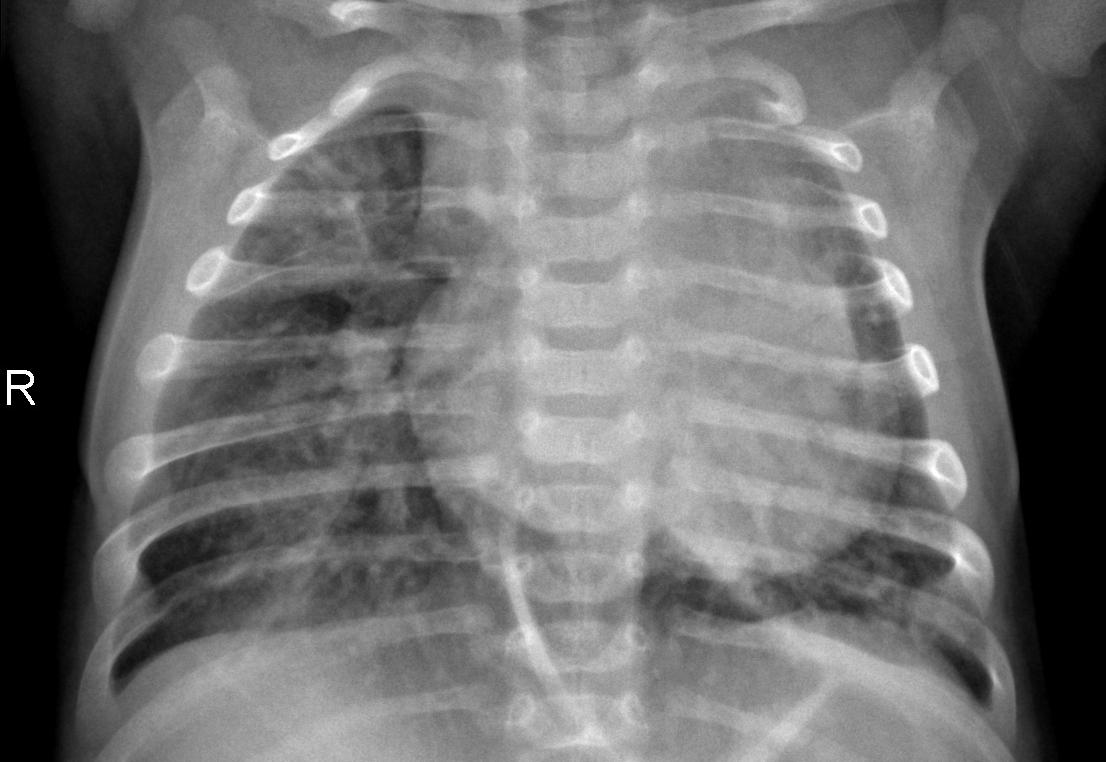

In [3]:
image = PIL.Image.open('../kaggle/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')

image

In [4]:
train = '../kaggle/chest_xray/train'
test = '../kaggle/chest_xray/test'
validation = '../kaggle/chest_xray/val'

In [5]:
training_generator = ImageDataGenerator(rescale=1/255)

data_train = training_generator.flow_from_directory(train, target_size=(256,256))

Found 5216 images belonging to 2 classes.


In [6]:
validation_generator = ImageDataGenerator(rescale=1/255)

data_valid = validation_generator.flow_from_directory(validation, target_size=(256,256))

Found 16 images belonging to 2 classes.


In [7]:
test_generator = ImageDataGenerator(rescale=1/255)

data_test = test_generator.flow_from_directory(test, target_size=(256,256))

Found 624 images belonging to 2 classes.


## CNN

In [8]:
from tensorflow.keras import regularizers

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    #tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    #tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(2,activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2025-02-03 10:06:41.471395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1d:00.0, compute capability: 7.0


In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc','f1_score'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 123, 123, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 121, 121, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 119, 119, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 117, 117, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 438048)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    28,035,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,755,618 (109.69 MB)

 Trainable params: 28,755,618 (109.69 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)
#checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [13]:
# history = model.fit(data_train,epochs=100,validation_data=data_valid)
history = model.fit(
    data_train,
#     steps_per_epoch=len(data_train),
    epochs=20,
    validation_data=data_valid,
#     validation_steps=len(data_valid)
#     callbacks=[checkpoint]
    callbacks=[callbacks]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-02-03 10:06:58.000827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2025-02-03 10:06:59.295113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1738595219.315647 4078761 service.cc:145] XLA service 0x7f2dac014b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738595219.315710 4078761 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-02-03 10:06:59.686649: I tensorflow/compiler/mlir/ten

163/163 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - acc: 0.7738 - f1_score: 0.6252 - loss: 0.5913 - val_acc: 0.6250 - val_f1_score: 0.5636 - val_loss: 0.7919
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 415ms/step - acc: 0.9471 - f1_score: 0.9304 - loss: 0.1645 - val_acc: 0.8750 - val_f1_score: 0.8730 - val_loss: 0.3278
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step - acc: 0.9115 - f1_score: 0.8845 - loss: 0.2690 - val_acc: 0.8750 - val_f1_score: 0.8750 - val_loss: 0.3076
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - acc: 0.9506 - f1_score: 0.9347 - loss: 0.1476 - val_acc: 1.0000 - val_f1_score: 1.0000 - val_loss: 0.1602
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - acc: 0.9788 - f1_score: 0.9720 - loss: 0.0828 - val_acc: 0.7500 - val_f1_score: 0.7333 - val_loss: 0.4464
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - acc: 0.9728 - f1_score: 0.9646 - loss: 0.0969 - val_acc: 1.0000 - val_f1_score: 1.0000 - val_loss: 0.0904
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━

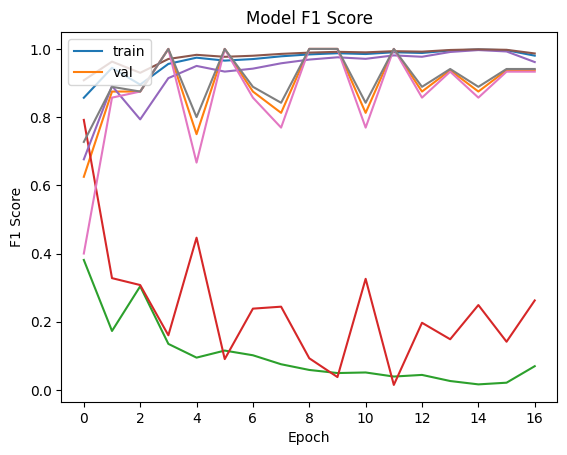

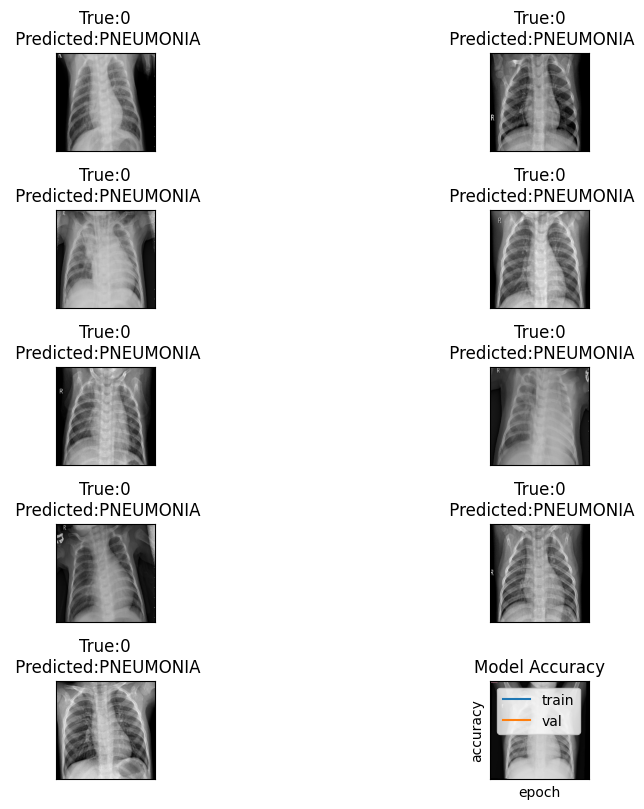

In [26]:
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy'),
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

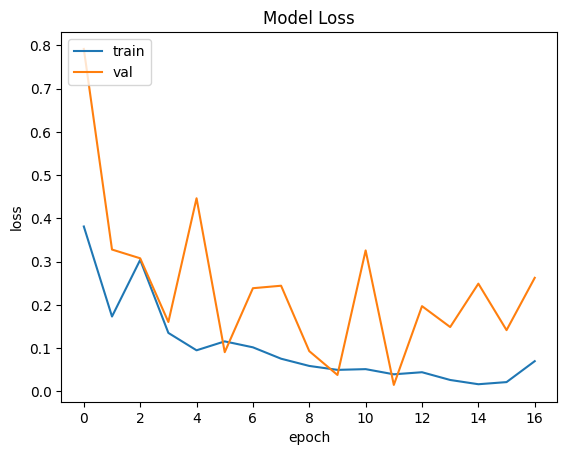

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss'),
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

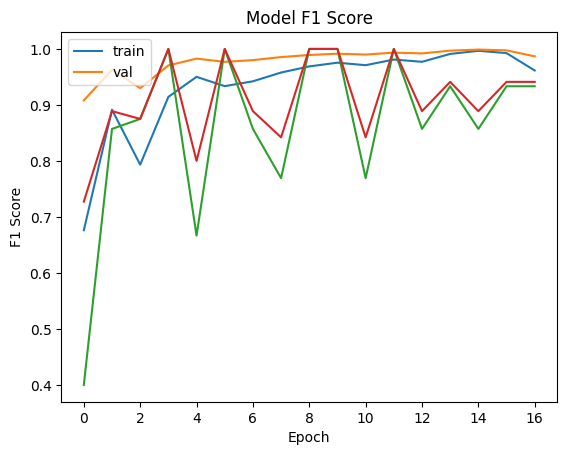

In [28]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title("Model F1 Score")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.legend(['train','val'],loc="upper left")
plt.show()

In [17]:
results = model.evaluate(data_test,verbose=0)
print(results)

[2.534691572189331, 0.7307692170143127, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.44736838, 0.8220338 ], dtype=float32)>]


In [18]:
print("    Test Loss : {:.5f}".format(results[0]))
print("Test Accuracy : {:.2f}".format(results[1]*100))

    Test Loss : 2.53469
Test Accuracy : 73.08


In [19]:
# pred = model.predict(data_test)
# pred = np.argmax(pred,axis=1)

# labels = (data_test.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# pred - [labels[k] for k in pred]

pred = model.predict(data_test)
pred = np.argmax(pred, axis=1)

labels = data_test.class_indices
labels = {v: k for k, v in labels.items()}

# Corrected line: Assign the modified values to 'pred'
pred = [labels[k] for k in pred]

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step


In [20]:
print(pred)

['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONI

In [21]:
from sklearn.metrics import classification_report

y_test = list(data_test.labels)
# print(y_test)
# Example mapping from class names to numeric labels
class_to_label = {0 :"NORMAL", 1 :"PNEUMONIA"}

# Convert true labels (strings) to numeric labels
numeric_true_labels = [class_to_label.get(label, -1) for label in y_test]

# Now use numeric_true_labels in the classification report
print(classification_report(numeric_true_labels, pred))




              precision    recall  f1-score   support

      NORMAL       0.33      0.10      0.15       234
   PNEUMONIA       0.62      0.88      0.73       390

    accuracy                           0.59       624
   macro avg       0.47      0.49      0.44       624
weighted avg       0.51      0.59      0.51       624



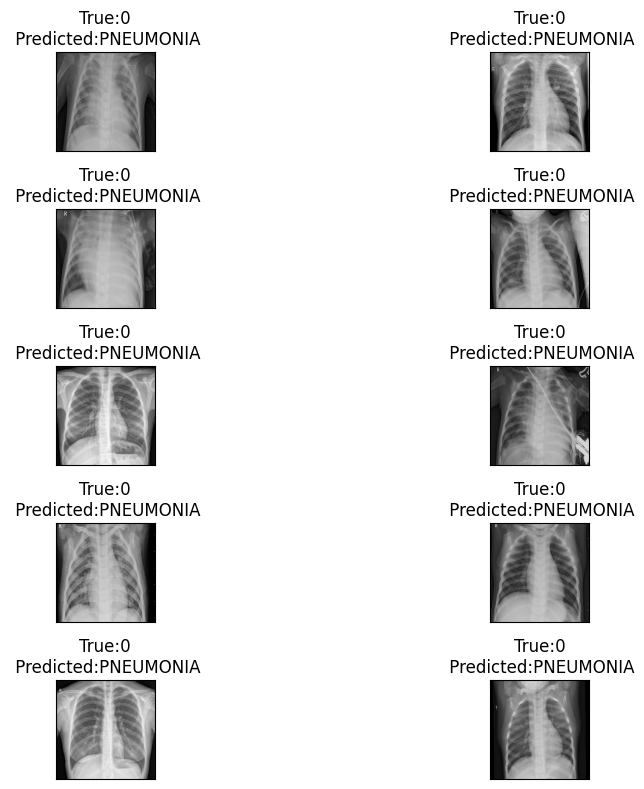

In [29]:
batch_images, batch_labels = next(data_test)

fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(12,8),subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(batch_images[i])
    ax.set_title(f"True:{data_test.classes[i]}\n Predicted:{pred[i]}")

plt.tight_layout()
plt.show()
                 

In [30]:
my_model = model.save('pneumonia_detection.h5')